## SANITY CHECK

Is necessary, check the datas is correct. 
For this purpouse, generate a intensity graph, with three axis: AX-x = Vlsr and FREQ, AX-y = Jy/beam. 

*NOTE:* 
- item the intensity is the sum of all data
- item is necessary to fix the range of velocity 
- item check the velocity of rest frequency 

remember that:

$$ V_i = CRVAL + CRDEL (i - CRPIX) $$

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from astropy.wcs import WCS
from astropy import constants as const

# Define the filenames of the two data cubes
file1 = 'C:/Users/macka/OneDrive/Documentos/Master/PYTHON_CODES/RESULTS/FITS/cube_with_vel.fits'  # Replace with the actual filename of the first cube
file2 = 'C:/Users/macka/OneDrive/Documentos/Master/PYTHON_CODES/RESULTS/FITS/cube_Spect_resampl_ALL.fits'  # Replace with the actual filename of the second cube

# Define the velocity range for integration in km/s
vel_min = 200.0 * 1000  # Convert to m/s
vel_max = 260.0 * 1000  # Convert to m/s


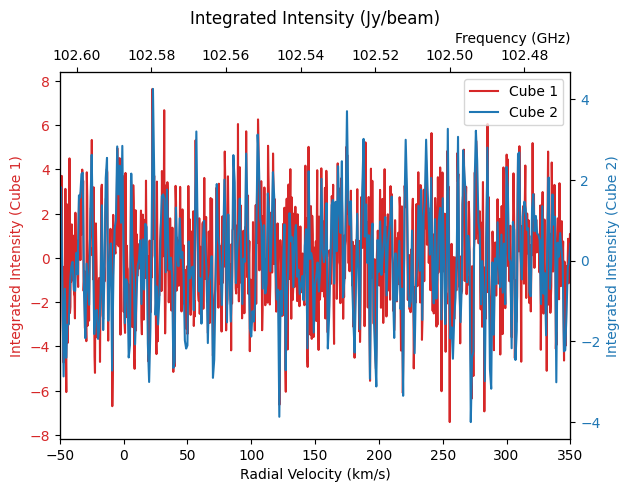

In [36]:
# Function to calculate the integrated intensity from a data cube (all cube)
def integrated_intensity(filename, vel_range):
    """
    Calculates the 1D integrated intensity *as a function of velocity*
    of a data cube within a given velocity range.

    Args:
        filename (str): Path to the FITS data cube file.
        vel_range (tuple): Tuple containing the minimum and maximum velocity (in m/s)
                           for integration.

    Returns:
        tuple: A tuple containing the radial velocity array (in km/s) and the
               spatially integrated intensity array *over the velocity range*.
               Returns None if there are issues with the header.
    """
    try:
        with fits.open(filename) as hdul:
            data = hdul[0].data
            header = hdul[0].header
            wcs = WCS(header)

            # Check if spectral axis information is present
            if 'CRVAL3' not in header or 'CDELT3' not in header or 'CUNIT3' not in header or 'CRPIX3' not in header:
                print(f"Error: Could not find necessary spectral axis parameters in the header of {filename}.")
                return None

            # Get spectral axis information
            rest_freq = header.get('RESTFRQ') * u.Hz if 'RESTFRQ' in header else None
            crval = header['CRVAL3'] * u.Unit(header['CUNIT3'])
            cdelt = header['CDELT3'] * u.Unit(header['CUNIT3'])
            crpix = header['CRPIX3']

            # Convert velocity range to the units of the spectral axis
            vel_min_unit = vel_range[0] * u.m / u.s
            vel_max_unit = vel_range[1] * u.m / u.s

            # Determine the channel range corresponding to the velocity range
            if header['CTYPE3'].startswith('FREQ'):
                if rest_freq is None:
                    print(f"Error: RESTFRQ not found in the header of {filename}, cannot convert frequency to velocity.")
                    return None
                v_min_equiv = rest_freq * (1 - vel_max_unit / const.c).to(crval.unit, equivalencies=u.doppler_radio(rest_freq))
                v_max_equiv = rest_freq * (1 - vel_min_unit / const.c).to(crval.unit, equivalencies=u.doppler_radio(rest_freq))

                # Determine the channel range corresponding to the velocity range
                start_chan = np.argmin(np.abs((np.arange(data.shape[0]) - (crpix - 1)) * cdelt + crval - v_max_equiv))
                end_chan = np.argmin(np.abs((np.arange(data.shape[0]) - (crpix - 1)) * cdelt + crval - v_min_equiv))

                if start_chan > end_chan:
                    start_chan, end_chan = end_chan, start_chan

                # Extract the relevant velocity channels
                spectral_axis_freq = (np.arange(data.shape[0]) - (crpix - 1)) * cdelt + crval
                spectral_axis_vel = rest_freq * (1 - spectral_axis_freq / rest_freq).to(u.km / u.s, equivalencies=u.doppler_radio(rest_freq))
                data_slice = data[start_chan:end_chan+1, :, :]

            elif header['CTYPE3'].startswith('VRAD'):
                # Determine the channel range directly from velocity
                start_chan = np.argmin(np.abs((np.arange(data.shape[0]) - (crpix - 1)) * cdelt + crval - vel_min_unit.to(crval.unit)))
                end_chan = np.argmin(np.abs((np.arange(data.shape[0]) - (crpix - 1)) * cdelt + crval - vel_max_unit.to(crval.unit)))

                if start_chan > end_chan:
                    start_chan, end_chan = end_chan, start_chan

                # Extract the relevant velocity channels
                spectral_axis_vel = ((np.arange(data.shape[0]) - (crpix - 1)) * cdelt + crval).to(u.km / u.s)
                data_slice = data[start_chan:end_chan+1, :, :]

            else:
                print(f"Error: Spectral axis type '{header['CTYPE3']}' not recognized in {filename}.")
                return None

            # Integrate over the spatial dimensions (axis 1 and 2 for a 3D cube)
            integrated_intensity_map_vs_vel = np.nansum(data_slice, axis=(1, 2))

            return spectral_axis_vel[start_chan:end_chan+1].value, integrated_intensity_map_vs_vel

    except FileNotFoundError:
        print(f"Error: File '{filename}' not found.")
        return None
    except KeyError as e:
        print(f"Error: Key '{e}' not found in the header of {filename}.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while processing {filename}: {e}")
        return None

# Calculate integrated intensity for the first cube
result1 = integrated_intensity(file1, (vel_min, vel_max))
if result1:
    vel_axis1, int_intensity1 = result1
else:
    vel_axis1, int_intensity1 = None, None

# Calculate integrated intensity for the second cube
result2 = integrated_intensity(file2, (vel_min, vel_max))
if result2:
    vel_axis2, int_intensity2 = result2
else:
    vel_axis2, int_intensity2 = None, None

# Plotting
if vel_axis1 is not None and int_intensity1 is not None and vel_axis2 is not None and int_intensity2 is not None:
    fig, ax1 = plt.subplots()

    # Plot the first integrated intensity curve
    color = 'tab:red'
    ax1.set_xlabel('Radial Velocity (km/s)')
    ax1.set_ylabel('Integrated Intensity (Cube 1)', color=color)
    ax1.plot(vel_axis1, int_intensity1, color=color, label='Cube 1')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xlim(vel_min / 1000, vel_max / 1000) # Set velocity limits

    # Create a second y-axis for the second curve
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Integrated Intensity (Cube 2)', color=color)
    ax2.plot(vel_axis2, int_intensity2, color=color, label='Cube 2')
    ax2.tick_params(axis='y', labelcolor=color)

    # Get frequency information to create the top x-axis
    with fits.open(file1) as hdul1:
        header1 = hdul1[0].header
        rest_freq1 = header1.get('RESTFRQ') * u.Hz if 'RESTFRQ' in header1 else None
        crval1 = header1.get('CRVAL3') * u.Unit(header1.get('CUNIT3')) if 'CRVAL3' in header1 and 'CUNIT3' in header1 else None
        cdelt1 = header1.get('CDELT3') * u.Unit(header1.get('CUNIT3')) if 'CDELT3' in header1 and 'CUNIT3' in header1 else None
        crpix1 = header1.get('CRPIX3') if 'CRPIX3' in header1 else None
        ctype3_1 = header1.get('CTYPE3')

        if rest_freq1 is not None and crval1 is not None and cdelt1 is not None and crpix1 is not None and ctype3_1 is not None:
            if ctype3_1.startswith('VRAD'):
                freq_min = rest_freq1 * (1 - (vel_max * u.m / u.s) / const.c)
                freq_max = rest_freq1 * (1 - (vel_min * u.m / u.s) / const.c)
            elif ctype3_1.startswith('FREQ'):
                # If frequency is the axis, we can try to find the corresponding frequency range
                # based on the velocity range, assuming a rest frequency is available.
                freq_at_vel_min = rest_freq1 * (1 - (vel_min * u.m / u.s) / const.c).to(rest_freq1.unit, equivalencies=u.doppler_radio(rest_freq1))
                freq_at_vel_max = rest_freq1 * (1 - (vel_max * u.m / u.s) / const.c).to(rest_freq1.unit, equivalencies=u.doppler_radio(rest_freq1))
                freq_min = min(freq_at_vel_min, freq_at_vel_max)
                freq_max = max(freq_at_vel_max, freq_at_vel_min)
            else:
                freq_min, freq_max = None, None
        else:
            freq_min, freq_max = None, None

    if freq_min is not None and freq_max is not None:
        ax3 = ax1.twiny()
        ax3.set_xlabel('Frequency (GHz)', position=(1, 1), ha='right')
        ax3.set_xlim(freq_max.value / 1e9, freq_min.value / 1e9) # Convert to GHz

    fig.tight_layout()
    plt.title('Integrated Intensity (Jy/beam)')
    fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
    plt.show()

else:
    print("Could not generate the plot due to errors in processing the data cubes.")

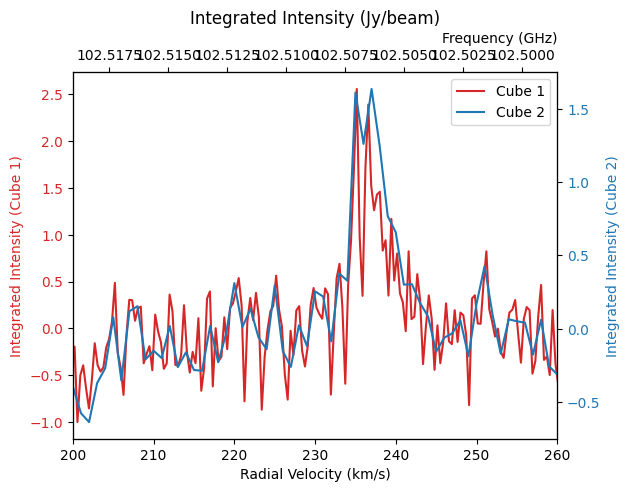

In [10]:
# Function to calculate the integrated intensity from a data cube (with selction region)
def integrated_intensity(filename, vel_range):
    """
    Calculates the 1D integrated intensity *as a function of velocity*
    of a data cube within a given velocity range and within a spatial region.

    Args:
        filename (str): Path to the FITS data cube file.
        vel_range (tuple): Tuple containing the minimum and maximum velocity (in m/s)
                           for integration.

    Returns:
        tuple: A tuple containing the radial velocity array (in km/s) and the
               spatially integrated intensity array *over the velocity range*.
    """
    # Region of interest (pixels)
    x_min, x_max = 49, 75
    y_min, y_max = 62, 88

    try:
        with fits.open(filename) as hdul:
            data = hdul[0].data
            header = hdul[0].header
            wcs = WCS(header)

            if 'CRVAL3' not in header or 'CDELT3' not in header or 'CUNIT3' not in header or 'CRPIX3' not in header:
                print(f"Error: Could not find necessary spectral axis parameters in the header of {filename}.")
                return None

            rest_freq = header.get('RESTFRQ') * u.Hz if 'RESTFRQ' in header else None
            crval = header['CRVAL3'] * u.Unit(header['CUNIT3'])
            cdelt = header['CDELT3'] * u.Unit(header['CUNIT3'])
            crpix = header['CRPIX3']

            vel_min_unit = vel_range[0] * u.m / u.s
            vel_max_unit = vel_range[1] * u.m / u.s

            if header['CTYPE3'].startswith('FREQ'):
                if rest_freq is None:
                    print(f"Error: RESTFRQ not found in the header of {filename}, cannot convert frequency to velocity.")
                    return None

                v_min_equiv = rest_freq * (1 - vel_max_unit / const.c).to(crval.unit, equivalencies=u.doppler_radio(rest_freq))
                v_max_equiv = rest_freq * (1 - vel_min_unit / const.c).to(crval.unit, equivalencies=u.doppler_radio(rest_freq))

                start_chan = np.argmin(np.abs((np.arange(data.shape[0]) - (crpix - 1)) * cdelt + crval - v_max_equiv))
                end_chan = np.argmin(np.abs((np.arange(data.shape[0]) - (crpix - 1)) * cdelt + crval - v_min_equiv))

                if start_chan > end_chan:
                    start_chan, end_chan = end_chan, start_chan

                spectral_axis_freq = (np.arange(data.shape[0]) - (crpix - 1)) * cdelt + crval
                spectral_axis_vel = rest_freq * (1 - spectral_axis_freq / rest_freq).to(u.km / u.s, equivalencies=u.doppler_radio(rest_freq))
                data_slice = data[start_chan:end_chan+1, :, :]

            elif header['CTYPE3'].startswith('VRAD'):
                start_chan = np.argmin(np.abs((np.arange(data.shape[0]) - (crpix - 1)) * cdelt + crval - vel_min_unit.to(crval.unit)))
                end_chan = np.argmin(np.abs((np.arange(data.shape[0]) - (crpix - 1)) * cdelt + crval - vel_max_unit.to(crval.unit)))

                if start_chan > end_chan:
                    start_chan, end_chan = end_chan, start_chan

                spectral_axis_vel = ((np.arange(data.shape[0]) - (crpix - 1)) * cdelt + crval).to(u.km / u.s)
                data_slice = data[start_chan:end_chan+1, :, :]

            else:
                print(f"Error: Spectral axis type '{header['CTYPE3']}' not recognized in {filename}.")
                return None

            # We spatially cut out the region where the source is located.
            data_slice = data_slice[:, y_min:y_max+1, x_min:x_max+1]

            # We integrate over the spatial region (not the whole cube).
            integrated_intensity_map_vs_vel = np.nansum(data_slice, axis=(1, 2))

            return spectral_axis_vel[start_chan:end_chan+1].value, integrated_intensity_map_vs_vel

    except FileNotFoundError:
        print(f"Error: File '{filename}' not found.")
        return None
    except KeyError as e:
        print(f"Error: Key '{e}' not found in the header of {filename}.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while processing {filename}: {e}")
        return None
# Calculate integrated intensity for the first cube
result1 = integrated_intensity(file1, (vel_min, vel_max))
if result1:
    vel_axis1, int_intensity1 = result1
else:
    vel_axis1, int_intensity1 = None, None

# Calculate integrated intensity for the second cube
result2 = integrated_intensity(file2, (vel_min, vel_max))
if result2:
    vel_axis2, int_intensity2 = result2
else:
    vel_axis2, int_intensity2 = None, None

# Plotting
if vel_axis1 is not None and int_intensity1 is not None and vel_axis2 is not None and int_intensity2 is not None:
    fig, ax1 = plt.subplots()

    # Plot the first integrated intensity curve
    color = 'tab:red'
    ax1.set_xlabel('Radial Velocity (km/s)')
    ax1.set_ylabel('Integrated Intensity (Cube 1)', color=color)
    ax1.plot(vel_axis1, int_intensity1, color=color, label='Cube 1')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xlim(vel_min / 1000, vel_max / 1000) # Set velocity limits

    # Create a second y-axis for the second curve
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Integrated Intensity (Cube 2)', color=color)
    ax2.plot(vel_axis2, int_intensity2, color=color, label='Cube 2')
    ax2.tick_params(axis='y', labelcolor=color)

    # Get frequency information to create the top x-axis
    with fits.open(file1) as hdul1:
        header1 = hdul1[0].header
        rest_freq1 = header1.get('RESTFRQ') * u.Hz if 'RESTFRQ' in header1 else None
        crval1 = header1.get('CRVAL3') * u.Unit(header1.get('CUNIT3')) if 'CRVAL3' in header1 and 'CUNIT3' in header1 else None
        cdelt1 = header1.get('CDELT3') * u.Unit(header1.get('CUNIT3')) if 'CDELT3' in header1 and 'CUNIT3' in header1 else None
        crpix1 = header1.get('CRPIX3') if 'CRPIX3' in header1 else None
        ctype3_1 = header1.get('CTYPE3')

        if rest_freq1 is not None and crval1 is not None and cdelt1 is not None and crpix1 is not None and ctype3_1 is not None:
            if ctype3_1.startswith('VRAD'):
                freq_min = rest_freq1 * (1 - (vel_max * u.m / u.s) / const.c)
                freq_max = rest_freq1 * (1 - (vel_min * u.m / u.s) / const.c)
            elif ctype3_1.startswith('FREQ'):
                # If frequency is the axis, we can try to find the corresponding frequency range
                # based on the velocity range, assuming a rest frequency is available.
                freq_at_vel_min = rest_freq1 * (1 - (vel_min * u.m / u.s) / const.c).to(rest_freq1.unit, equivalencies=u.doppler_radio(rest_freq1))
                freq_at_vel_max = rest_freq1 * (1 - (vel_max * u.m / u.s) / const.c).to(rest_freq1.unit, equivalencies=u.doppler_radio(rest_freq1))
                freq_min = min(freq_at_vel_min, freq_at_vel_max)
                freq_max = max(freq_at_vel_max, freq_at_vel_min)
            else:
                freq_min, freq_max = None, None
        else:
            freq_min, freq_max = None, None

    if freq_min is not None and freq_max is not None:
        ax3 = ax1.twiny()
        ax3.set_xlabel('Frequency (GHz)', position=(1, 1), ha='right')
        ax3.set_xlim(freq_max.value / 1e9, freq_min.value / 1e9) # Convert to GHz

    fig.tight_layout()
    plt.title('Integrated Intensity (Jy/beam)')
    fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
    plt.show()

else:
    print("Could not generate the plot due to errors in processing the data cubes.")

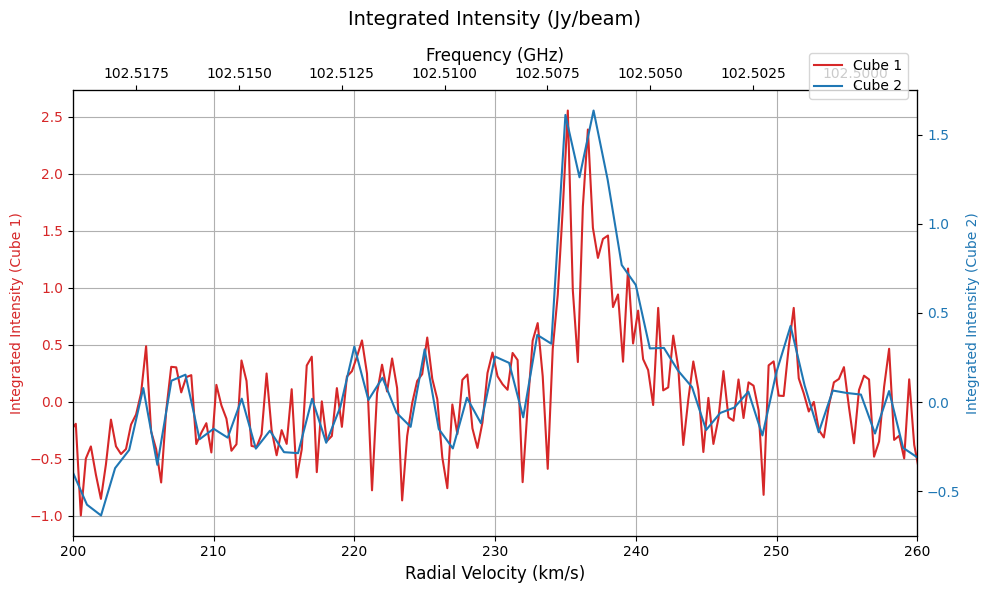

In [9]:
# Calculate integrated intensity for the two cubes
result1 = integrated_intensity(file1, (vel_min, vel_max))
result2 = integrated_intensity(file2, (vel_min, vel_max))

if result1 and result2:
    vel_axis1, int_intensity1 = result1
    vel_axis2, int_intensity2 = result2

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Curve of the first cube
    color1 = 'tab:red'
    ax1.plot(vel_axis1, int_intensity1, color=color1, label='Cube 1')
    ax1.set_xlabel('Radial Velocity (km/s)', fontsize=12)
    ax1.set_ylabel('Integrated Intensity (Cube 1)', color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.set_xlim(vel_min / 1000, vel_max / 1000)
    ax1.grid(True)

    # Curve of the second cube
    ax2 = ax1.twinx()
    color2 = 'tab:blue'
    ax2.plot(vel_axis2, int_intensity2, color=color2, label='Cube 2')
    ax2.set_ylabel('Integrated Intensity (Cube 2)', color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)

    # Extract RESTFRQ and calculate corresponding vertical line
    with fits.open(file1) as hdul:
        header = hdul[0].header
        rest_freq = header.get('RESTFRQ') * u.Hz
        ctype3 = header.get('CTYPE3')

        # Calculate speed corresponding to RESTFRQ
        vel_arr_kms = np.linspace(vel_min, vel_max, 1000) * u.m / u.s
        freq_arr = rest_freq * (1 - vel_arr_kms / const.c)
        freq_arr = freq_arr.to(u.GHz)


        # We also want the frequencies corresponding to specific speeds.
        v1 = 200 * u.km / u.s
        v2 = 275 * u.km / u.s
        f1 = rest_freq * (1 - v1 / const.c)
        f2 = rest_freq * (1 - v2 / const.c)
        f1 = f1.to(u.GHz)
        f2 = f2.to(u.GHz)

        # Upper shaft frequently
        ax3 = ax1.twiny()
        ax3.set_xlabel('Frequency (GHz)', fontsize=12)
        ax3.set_xlim(freq_arr[0].value, freq_arr[-1].value)



        #ax1.axvline(v1.value, color='orange', ls='--', lw=1.5, label='Vel at 200 km/s')
        #ax1.axvline(v2.value, color='orange', ls='--', lw=1.5, label='Vel at 275 km/s')
        ax3.axvline(f1.value, color='gray', ls='--', lw=0.5)
        ax3.axvline(f2.value, color='gray', ls='--', lw=0.5)

        v_rest = 0 * u.km/u.s
        #ax1.axvline(v_rest.value, color='green', ls=':', lw=1.5, label='RESTFRQ velocity')
        ax3.axvline(rest_freq.to(u.GHz).value, color='green', ls=':', lw=1.5)


    # Title and caption
    fig.suptitle('Integrated Intensity (Jy/beam)', fontsize=14)
    fig.legend(loc='upper right', bbox_to_anchor=(0.92, 0.92))
    fig.tight_layout()
    plt.show()

else:
    print("Could not generate the plot due to errors in processing the data cubes.")